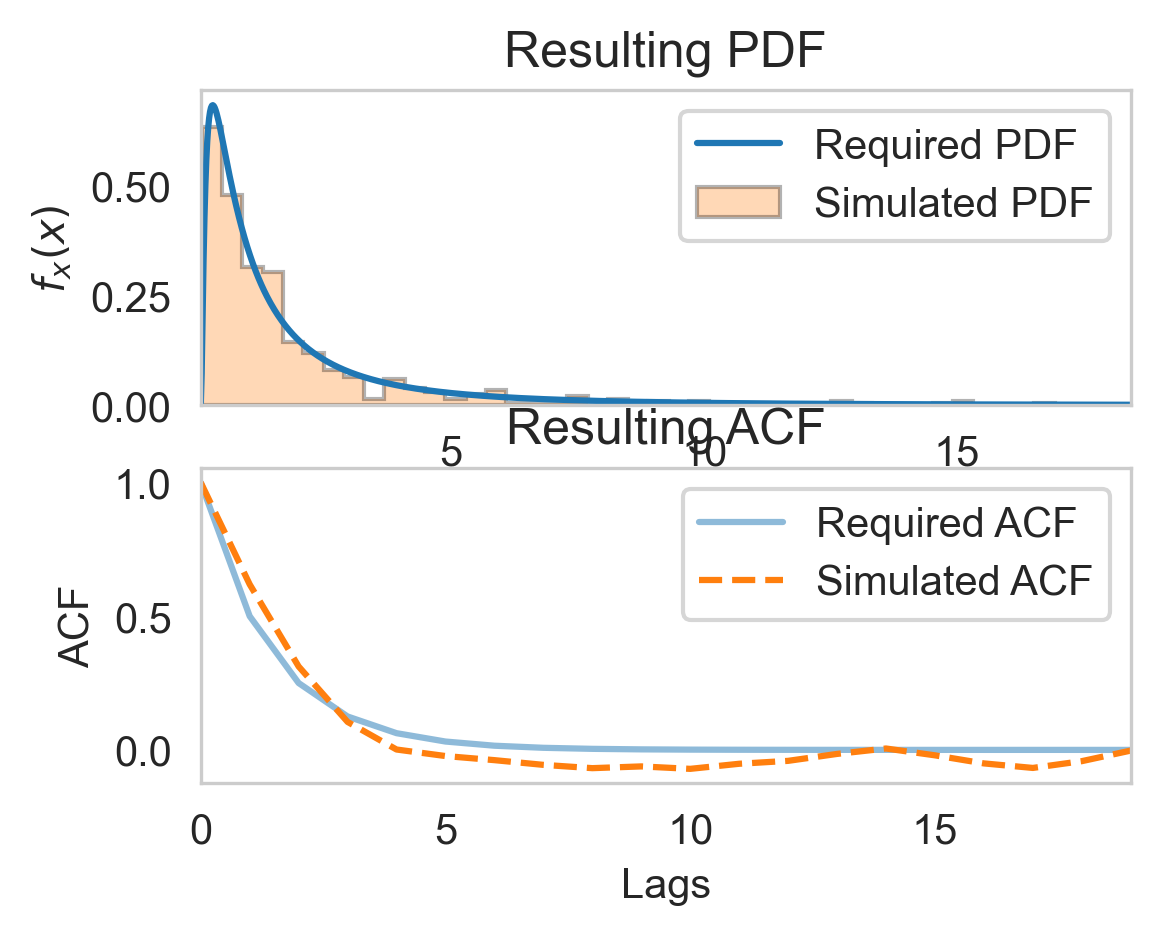

array([ 0.67423672,  0.40269076,  3.20676203,  3.20592586,  8.43752451,
       15.19401425,  1.1355924 ,  2.96381373,  3.77770583,  0.30682904,
        0.33433338,  0.53719694,  0.51838288,  0.39866956,  1.28149989,
        0.59880434,  0.44993045,  0.37812076,  0.55473284,  2.07151076,
        2.15258567,  2.44932447,  1.09326935,  0.39652092,  0.18835599,
        0.28541895,  0.81415063,  0.59384207,  0.51750374,  0.64751482,
        1.02185408,  0.99166729,  1.01620999,  0.87095393,  1.20360823,
        5.0431051 ,  2.42117336,  1.93833927,  0.86842818,  0.4287107 ,
        0.70110944,  2.49157422,  3.57413854,  0.98103239,  0.75947819,
        0.59473925,  1.11800423,  0.9878065 ,  0.88928523,  0.47653792,
        0.64423508,  0.74601157,  2.57085294,  0.95846015,  5.66637233,
        6.42940045, 15.23412336,  1.27785828,  0.45068175,  0.12603743,
        0.07804077,  0.13238119,  0.48049013,  0.2744601 ,  0.61475371,
        1.59083108,  1.19206834,  1.58057694,  1.55178074,  1.83

In [1]:
from generate_corr_sequence import gen_corr_sequence
import scipy.stats as st
import numpy as np

acf = 1 / (2 ** np.arange(20))

delays  = gen_corr_sequence(
    dist_obj=st.lognorm(s=1.2, loc=0.046, scale=1),
    L=500,
    target_acf=acf,
    debug=True,
)
delays

In [2]:
delays.size

500

In [3]:
acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))
acf_00 = np.zeros(5)
acf_00[0] = 1.0


In [4]:
acf_50

array([1.    , 0.5   , 0.25  , 0.125 , 0.0625])

In [5]:
acf_25

array([1.        , 0.25      , 0.0625    , 0.015625  , 0.00390625])

In [6]:
from collections import deque
import pandas as pd

scales = (
    0.1,
    0.2,
    0.4,
    0.8,
    1.6,
    3.2,
)
min_bound = 0.042
shape = 1.2


rows = deque()
for scale in scales:
    dist = st.lognorm(s=shape, loc=min_bound, scale=scale)
    mean, var = dist.stats()
    rows.append({
        r"$ S $": shape,
        "location": min_bound,
        "scale": scale,
        r"$\mu$": mean,
        r"$\sigma$": np.sqrt(var),
        "\num{95}\textsuperscript{th} percentile": dist.ppf(.95)
    })
    
df = pd.DataFrame(rows).set_index(["$ S $", "location", "scale"])
df

$\mu$   $\sigma$  \
$ S $ location scale                        
1.2   0.042    0.1    0.247443   0.368695   
               0.2    0.452887   0.737389   
               0.4    0.863773   1.474779   
               0.8    1.685547   2.949558   
               1.6    3.329093   5.899115   
               3.2    6.616186  11.798230   

                      \num{95}\textsuperscript{th} percentile  
$ S $ location scale                                           
1.2   0.042    0.1                                   0.761815  
               0.2                                   1.481630  
               0.4                                   2.921261  
               0.8                                   5.800522  
               1.6                                  11.559043  
               3.2                                  23.076087

In [7]:
print(
    df
    .to_latex(
        float_format="%0.2f"
    )
)

\begin{tabular}{lllrrr}
\toprule
 &  &  & $\mu$ & $\sigma$ & 
um{95}	extsuperscript{th} percentile \\
$ S $ & location & scale &  &  &  \\
\midrule
\multirow[t]{6}{*}{1.200000} & \multirow[t]{6}{*}{0.042000} & 0.100000 & 0.25 & 0.37 & 0.76 \\
 &  & 0.200000 & 0.45 & 0.74 & 1.48 \\
 &  & 0.400000 & 0.86 & 1.47 & 2.92 \\
 &  & 0.800000 & 1.69 & 2.95 & 5.80 \\
 &  & 1.600000 & 3.33 & 5.90 & 11.56 \\
 &  & 3.200000 & 6.62 & 11.80 & 23.08 \\
\cline{1-6} \cline{2-6}
\bottomrule
\end{tabular}



In [32]:
from typing import Tuple
import scipy.stats as stats

target_mean_var_s = (
    (2*0.050, 2*0.010),
    (2*0.100, 2*0.020),
    (2*0.200, 2*0.040),
    (2*0.400, 2*0.080),
    (2*0.800, 2*0.160),
    (2*1.600, 2*0.320),
)
loc = 0.046


def lognorm_with_params(loc: float | int, mean: float | int, var: float | int) -> Tuple[stats.rv_continuous, float, float]:
    sigma2 = np.log((var / np.square(mean - loc)) + 1)
    mu = np.log(mean - loc) - (sigma2 / 2)
    scale = np.exp(mu)
    s = np.sqrt(sigma2)
    return st.lognorm(loc=loc, scale=scale, s=s), scale, s


for (mean, var) in target_mean_var_s:
    dist, scale, s = lognorm_with_params(loc, mean, var)
    d_mean, d_var, *_ = dist.stats()
    print(f"PARAMS Scale: {scale} | S: {s}")
    print(f"MEAN Expected: {mean:0.02f}s | Actual {d_mean:0.02f}s.")
    print(f"VARIANCE Expected: {var:0.02f}s | Actual {d_var:0.02f}s.")
    print()


PARAMS Scale: 0.019262742222029956 | S: 1.4358351376115295
MEAN Expected: 0.10s | Actual 0.10s.
VARIANCE Expected: 0.02s | Actual 0.02s.

PARAMS Scale: 0.09395441436893014 | S: 0.9941256372246269
MEAN Expected: 0.20s | Actual 0.20s.
VARIANCE Expected: 0.04s | Actual 0.04s.

PARAMS Scale: 0.2765636681237385 | S: 0.7026462185427219
MEAN Expected: 0.40s | Actual 0.40s.
VARIANCE Expected: 0.08s | Actual 0.08s.

PARAMS Scale: 0.6660750170157892 | S: 0.4979760348629696
MEAN Expected: 0.80s | Actual 0.80s.
VARIANCE Expected: 0.16s | Actual 0.16s.

PARAMS Scale: 1.4602594752154132 | S: 0.35275518214689566
MEAN Expected: 1.60s | Actual 1.60s.
VARIANCE Expected: 0.32s | Actual 0.32s.

PARAMS Scale: 3.057188633662402 | S: 0.2497027915445451
MEAN Expected: 3.20s | Actual 3.20s.
VARIANCE Expected: 0.64s | Actual 0.64s.



In [43]:
def gamma_with_params(loc: float | int, mean: float | int, var: float | int) -> Tuple[stats.rv_continuous, float, float]:
    scale = var / (mean - loc)
    k = np.square(mean - loc) / var
    return st.gamma(a=k, loc=loc, scale=scale), scale, k

for (mean, var) in target_mean_var_s:
    dist, scale, k = gamma_with_params(loc, mean, var)
    d_mean, d_var, *_ = dist.stats()
    print(f"PARAMS Scale: {scale} | Shape: {k}")
    print(f"MEAN Expected: {mean:0.02f}s | Actual {d_mean:0.02f}s.")
    print(f"VARIANCE Expected: {var:0.02f}s | Actual {d_var:0.02f}s.")
    print()

PARAMS Scale: 0.19999999999999998 | Shape: 0.5000000000000001
MEAN Expected: 0.10s | Actual 0.10s.
VARIANCE Expected: 0.02s | Actual 0.02s.

PARAMS Scale: 0.19999999999999998 | Shape: 1.0000000000000002
MEAN Expected: 0.20s | Actual 0.20s.
VARIANCE Expected: 0.04s | Actual 0.04s.

PARAMS Scale: 0.19999999999999998 | Shape: 2.0000000000000004
MEAN Expected: 0.40s | Actual 0.40s.
VARIANCE Expected: 0.08s | Actual 0.08s.

PARAMS Scale: 0.19999999999999998 | Shape: 4.000000000000001
MEAN Expected: 0.80s | Actual 0.80s.
VARIANCE Expected: 0.16s | Actual 0.16s.

PARAMS Scale: 0.19999999999999998 | Shape: 8.000000000000002
MEAN Expected: 1.60s | Actual 1.60s.
VARIANCE Expected: 0.32s | Actual 0.32s.

PARAMS Scale: 0.19999999999999998 | Shape: 16.000000000000004
MEAN Expected: 3.20s | Actual 3.20s.
VARIANCE Expected: 0.64s | Actual 0.64s.



Mean 0.10 Var 0.02 ACF acf00


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.

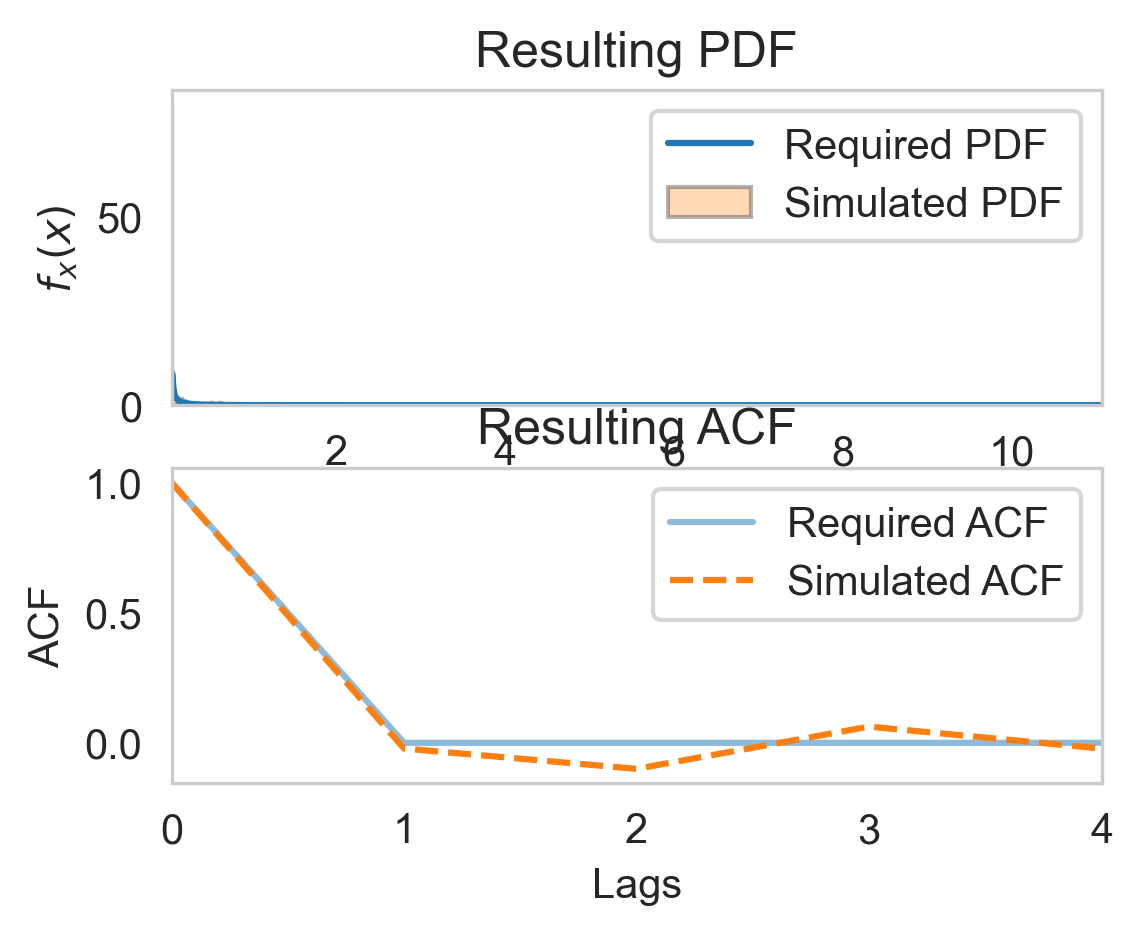

Mean 0.10 Var 0.02 ACF acf25


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.

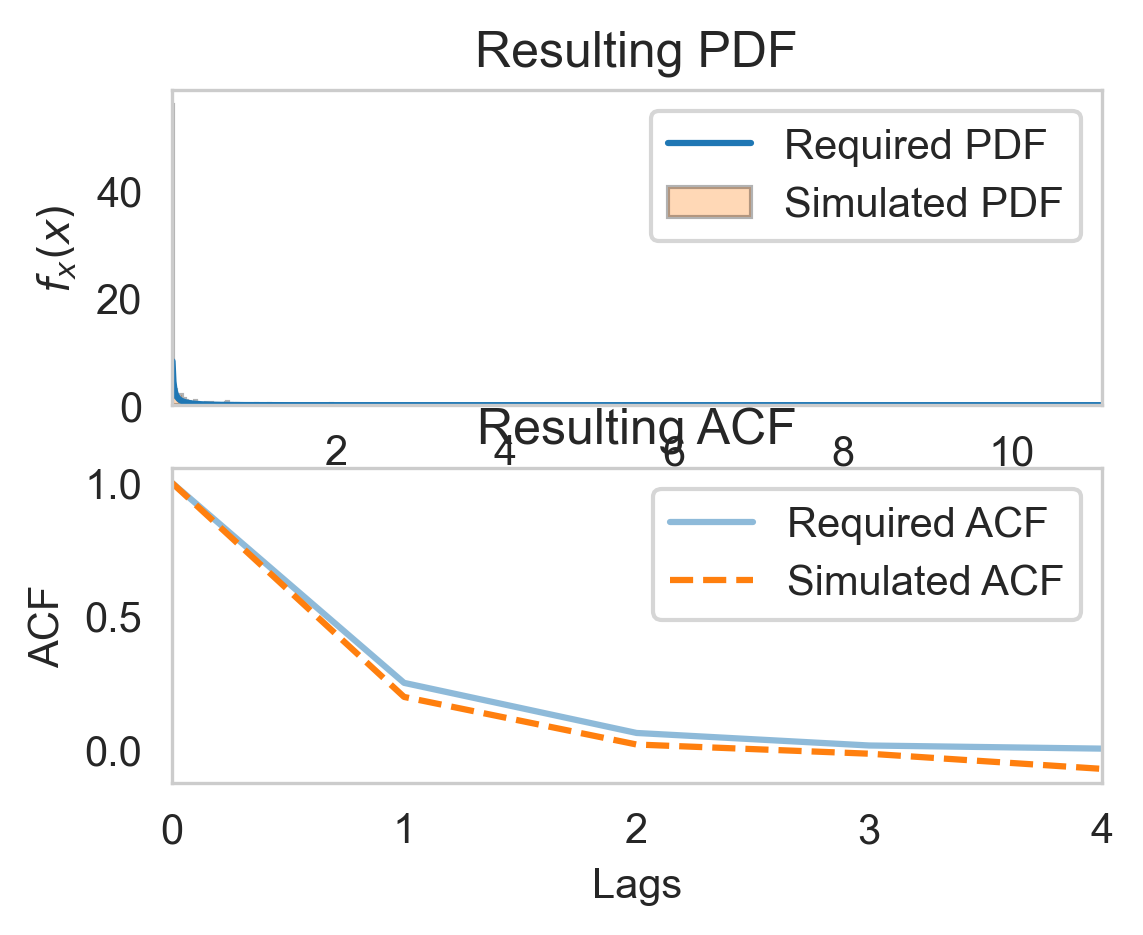

Mean 0.10 Var 0.02 ACF acf50


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.

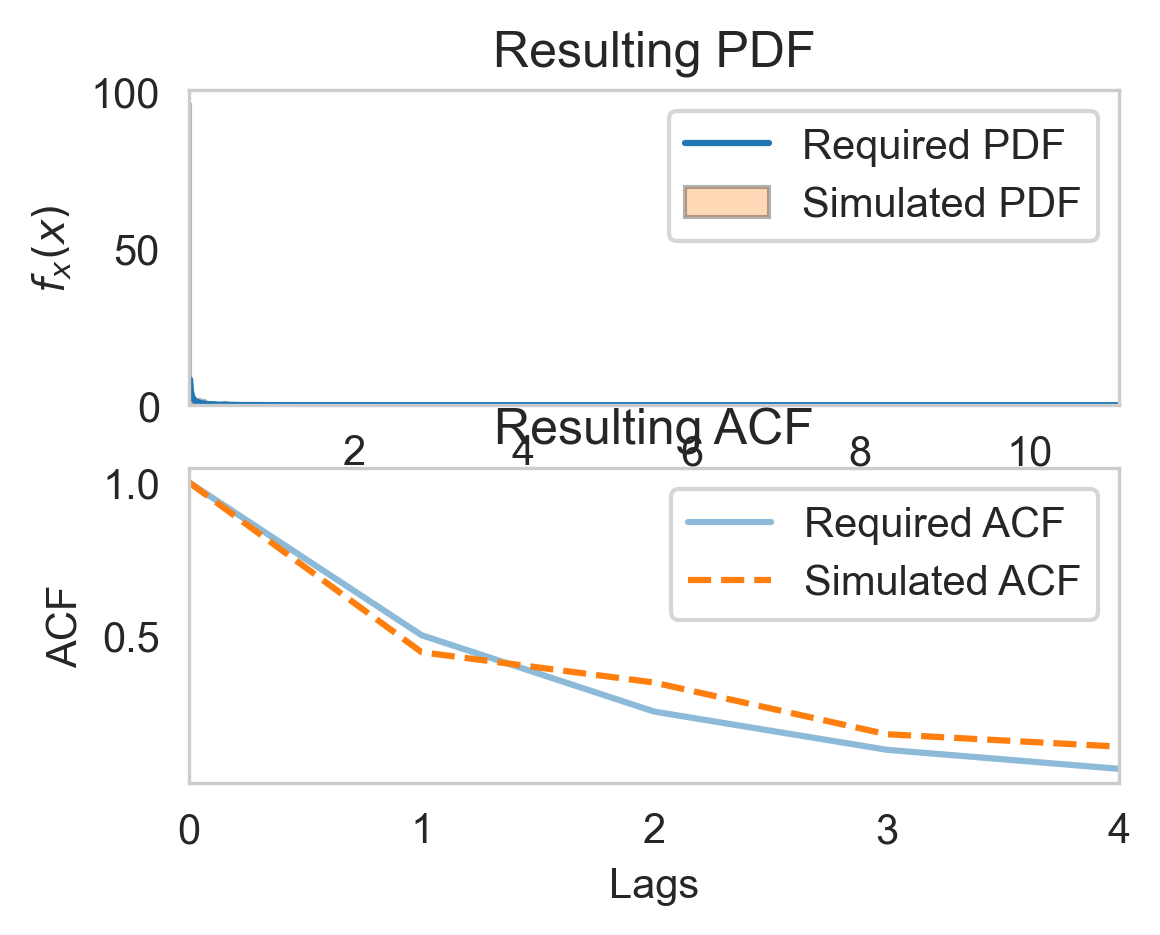

Mean 0.20 Var 0.04 ACF acf00


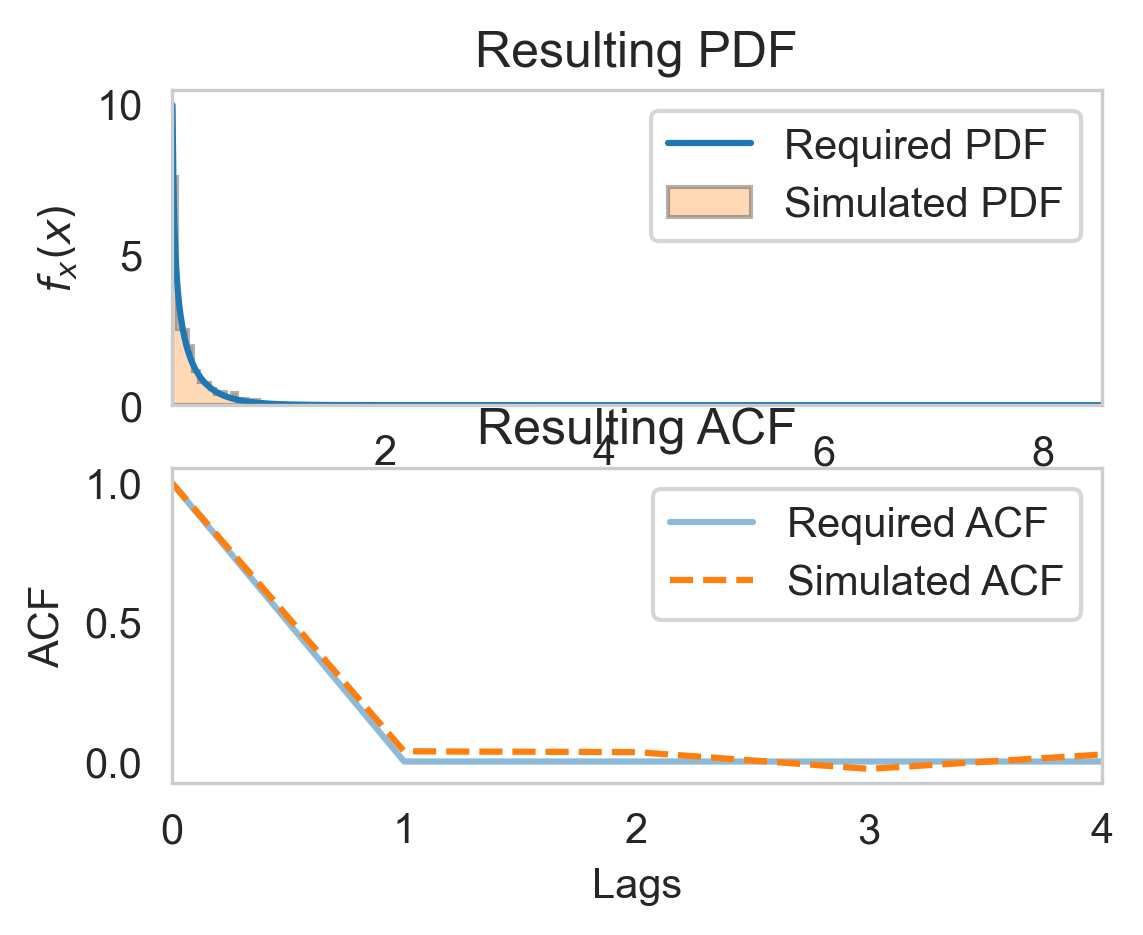

Mean 0.20 Var 0.04 ACF acf25


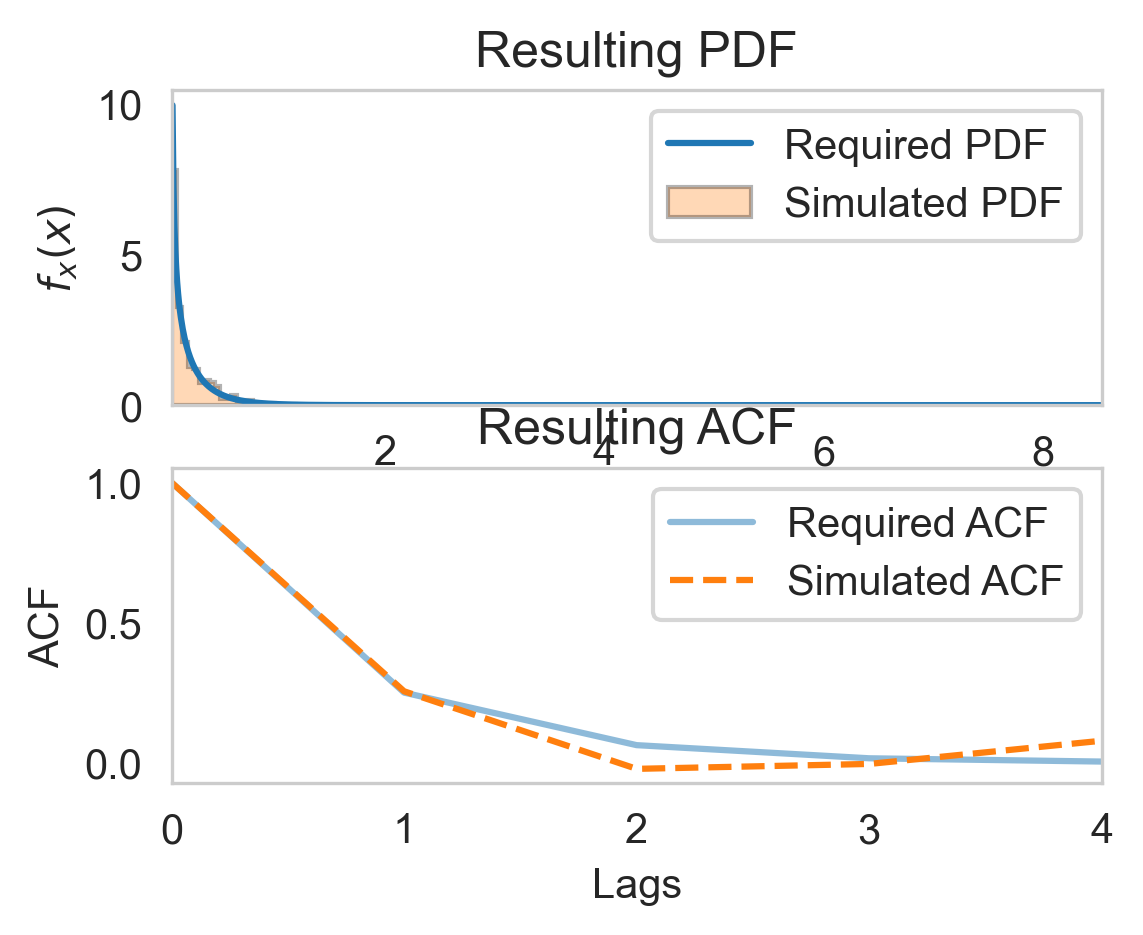

Mean 0.20 Var 0.04 ACF acf50


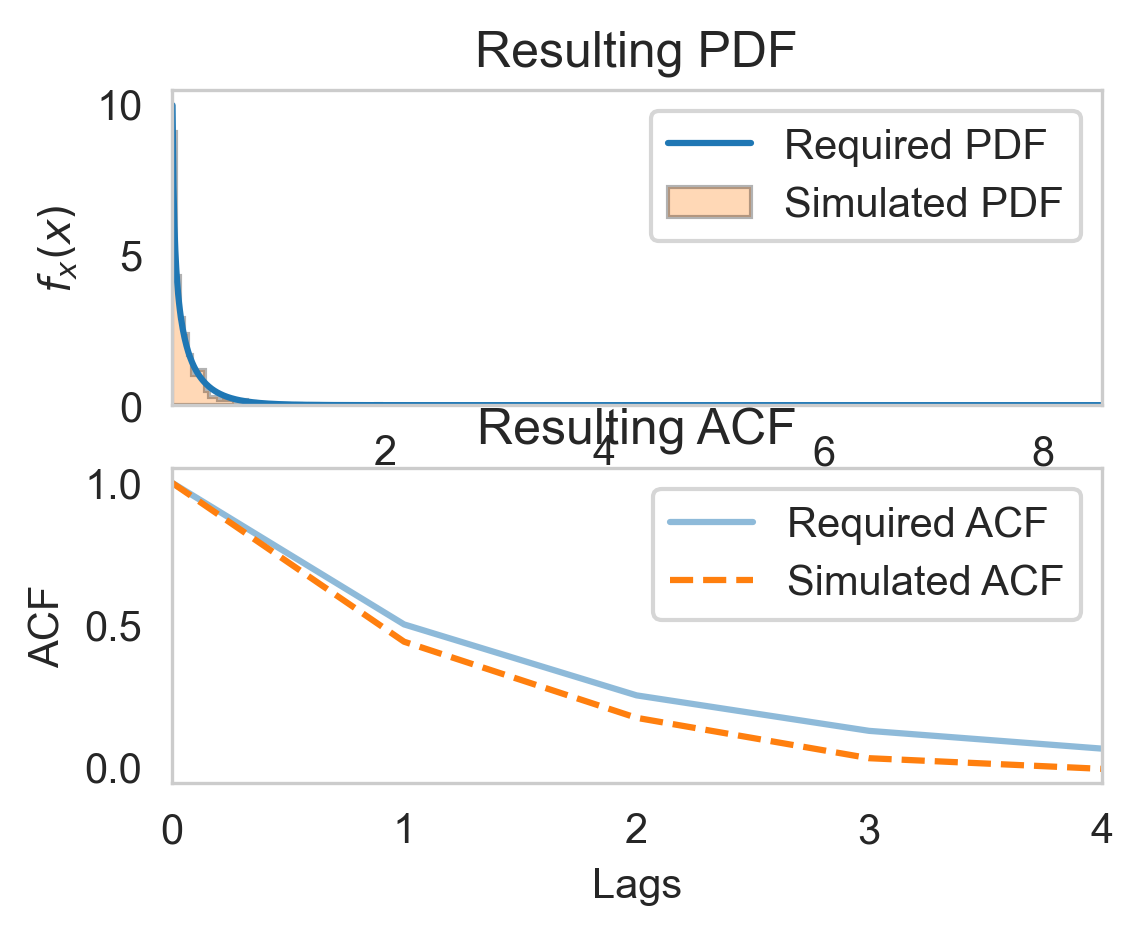

Mean 0.40 Var 0.08 ACF acf00


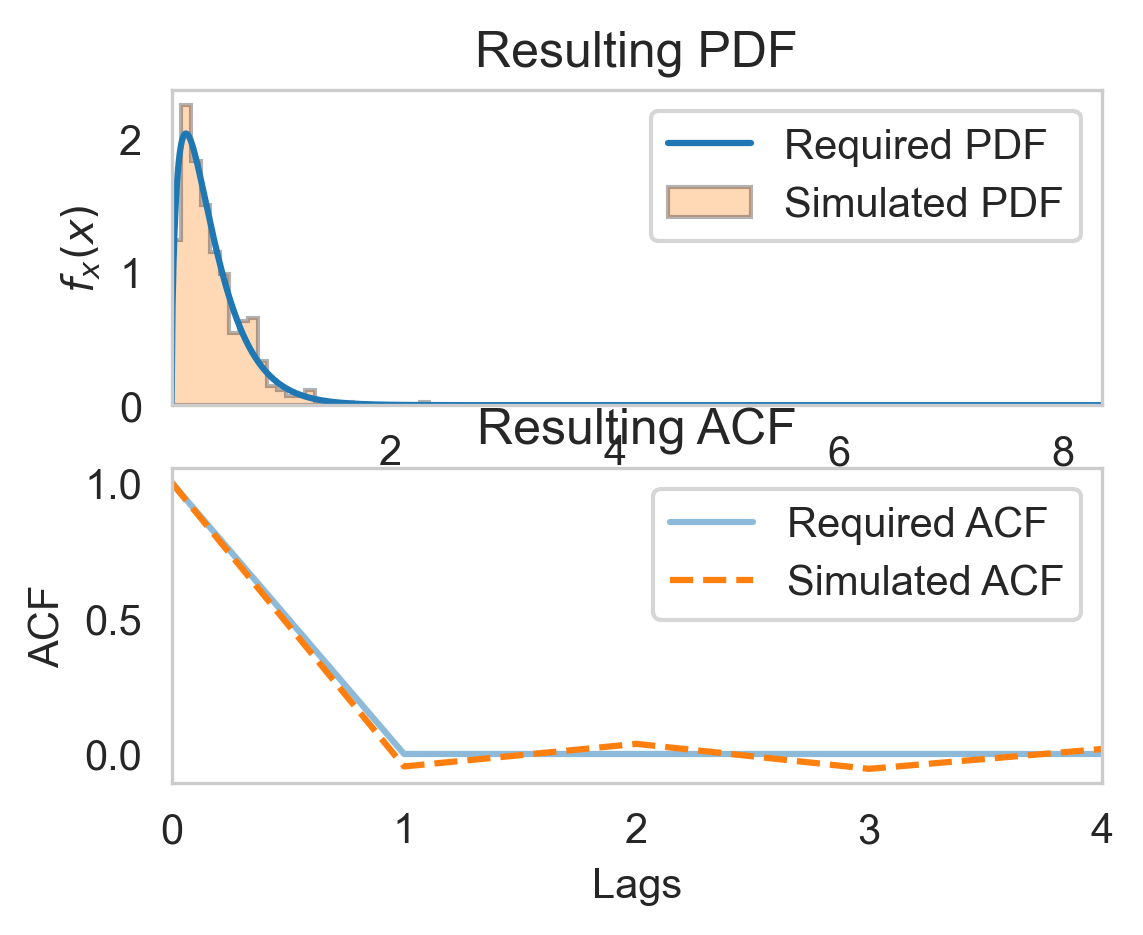

Mean 0.40 Var 0.08 ACF acf25


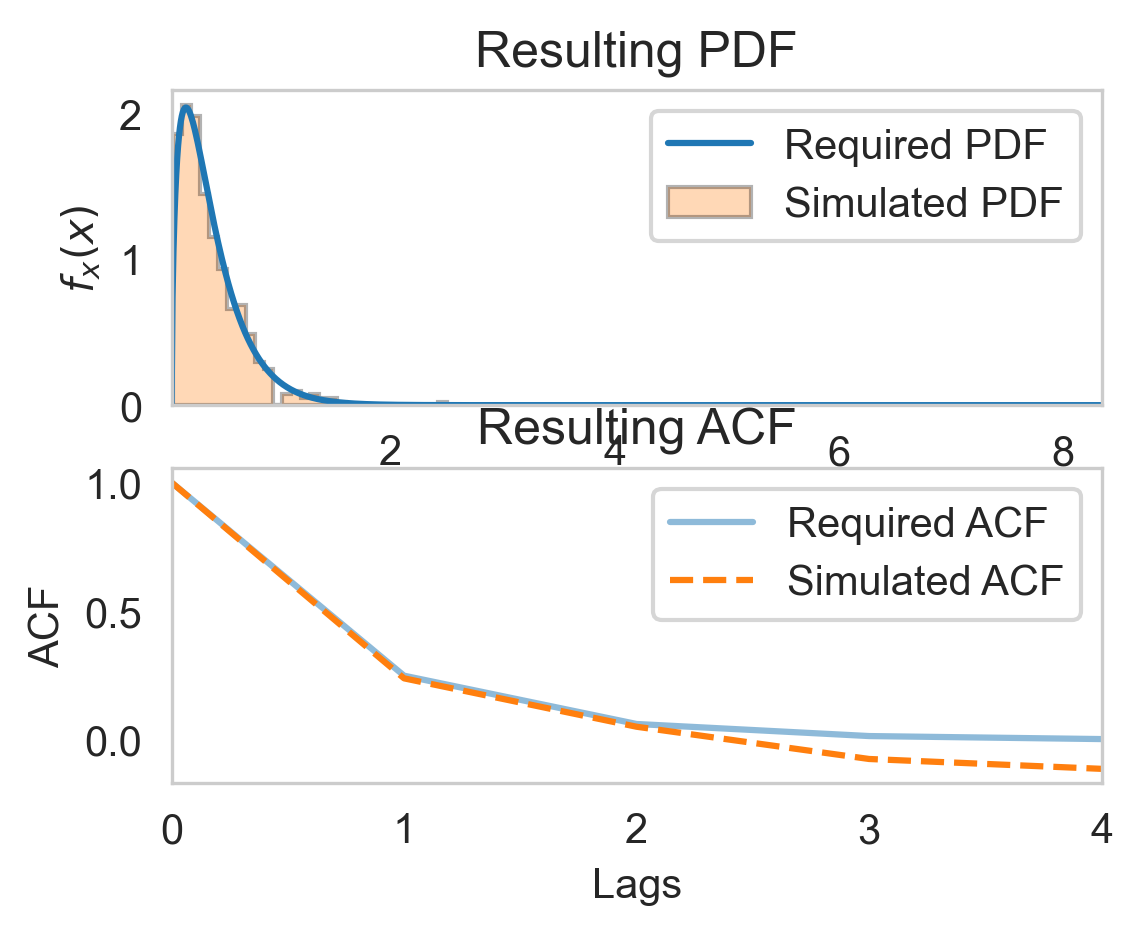

Mean 0.40 Var 0.08 ACF acf50


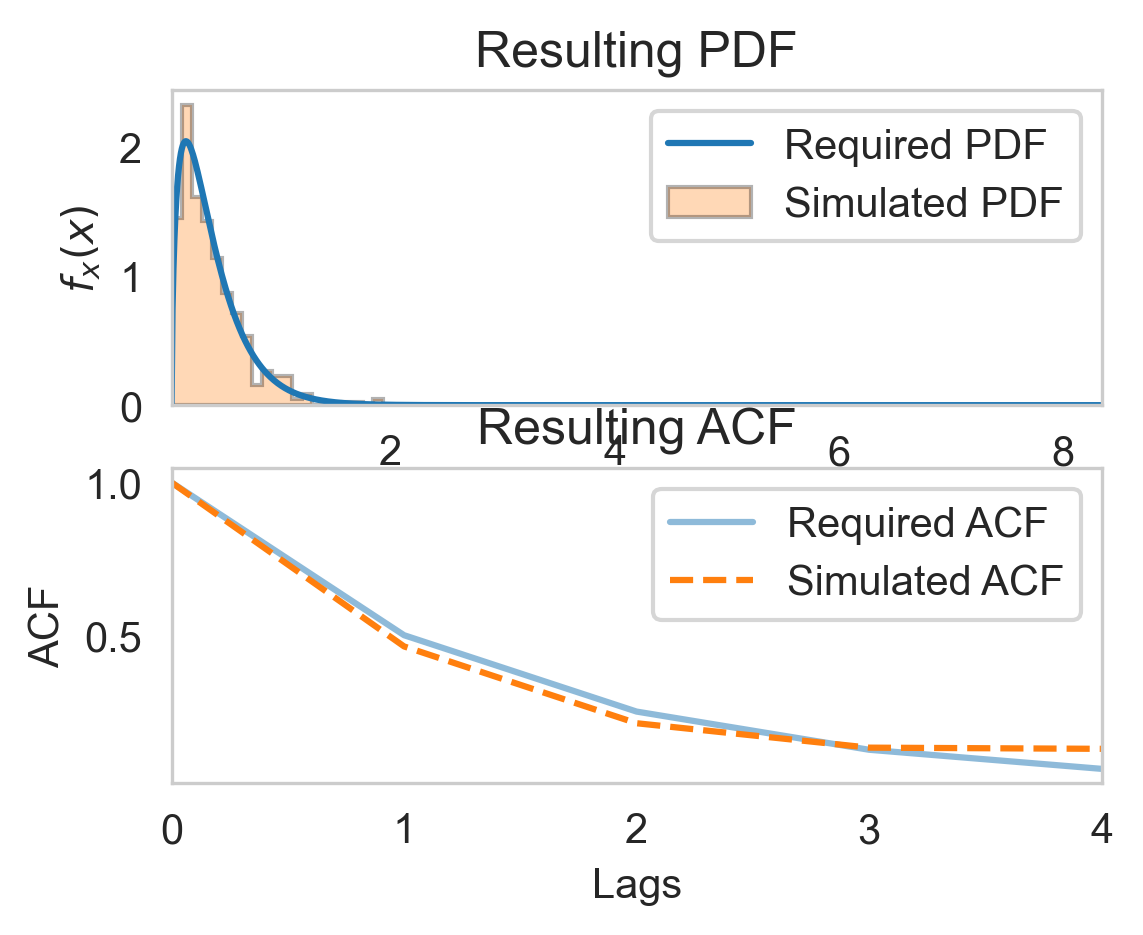

Mean 0.80 Var 0.16 ACF acf00


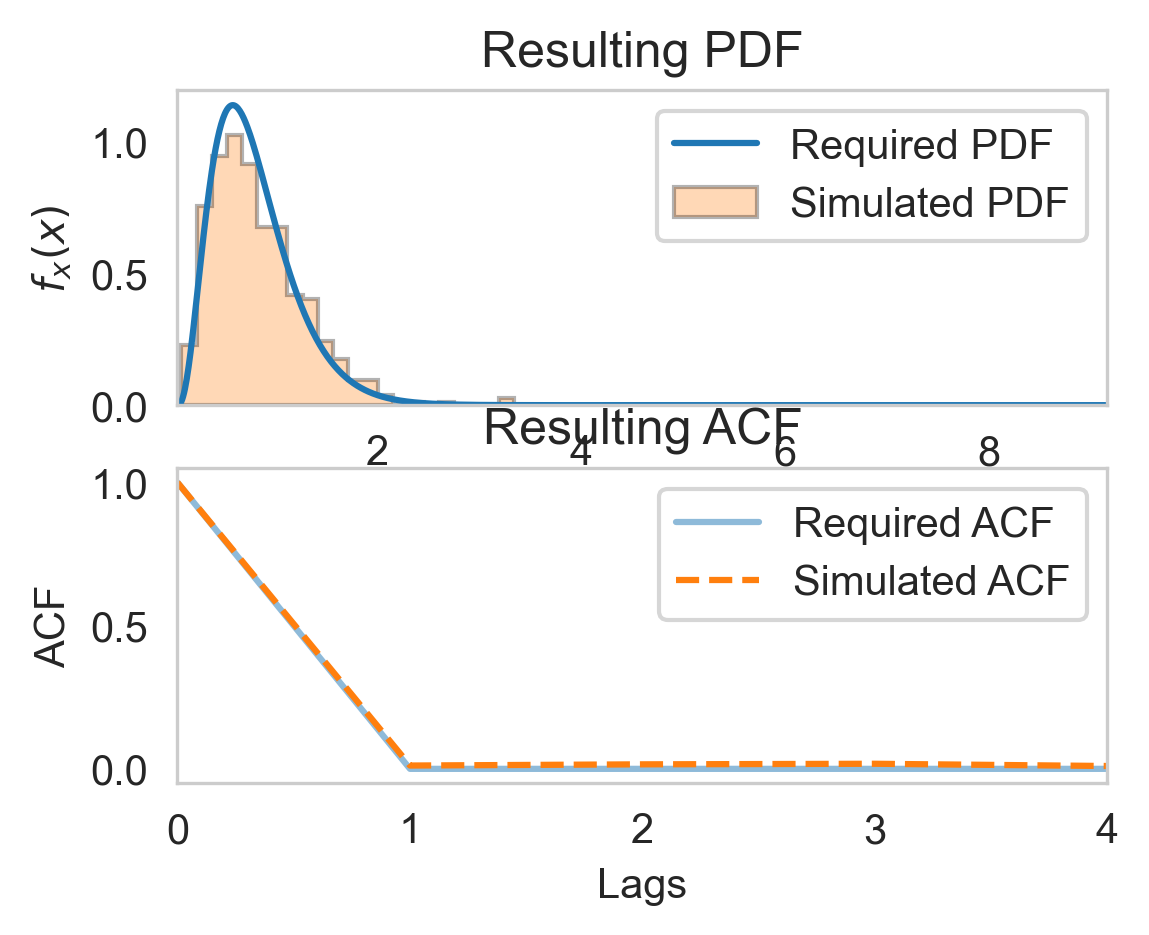

Mean 0.80 Var 0.16 ACF acf25


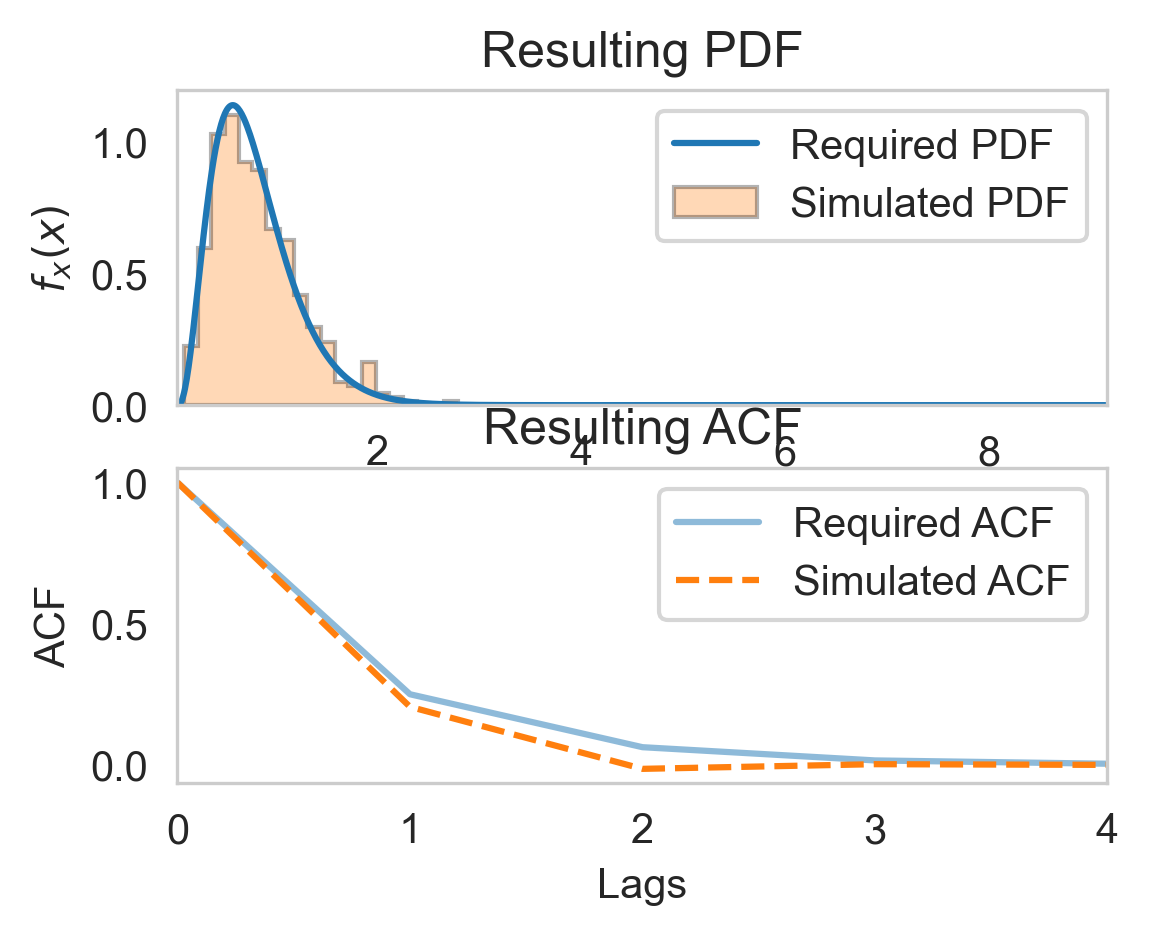

Mean 0.80 Var 0.16 ACF acf50


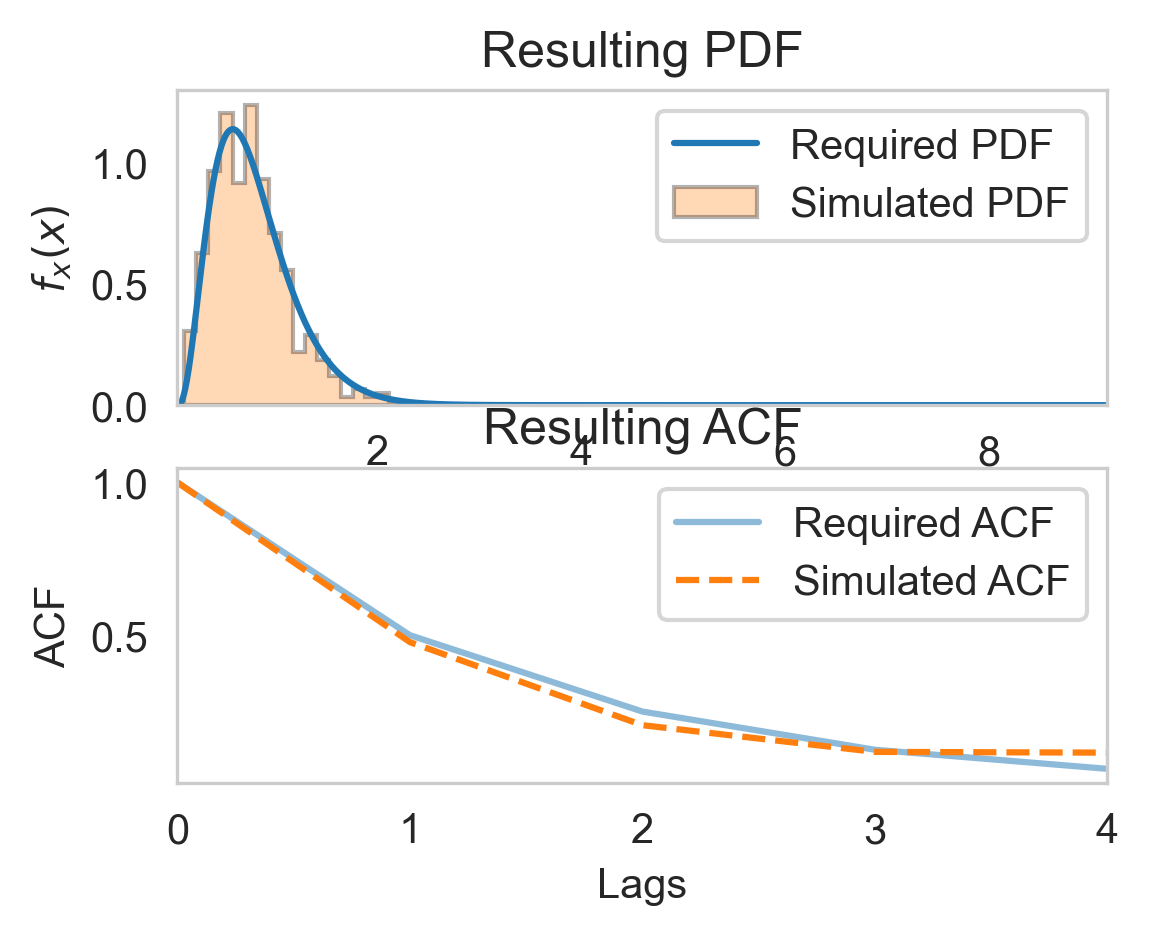

Mean 1.60 Var 0.32 ACF acf00


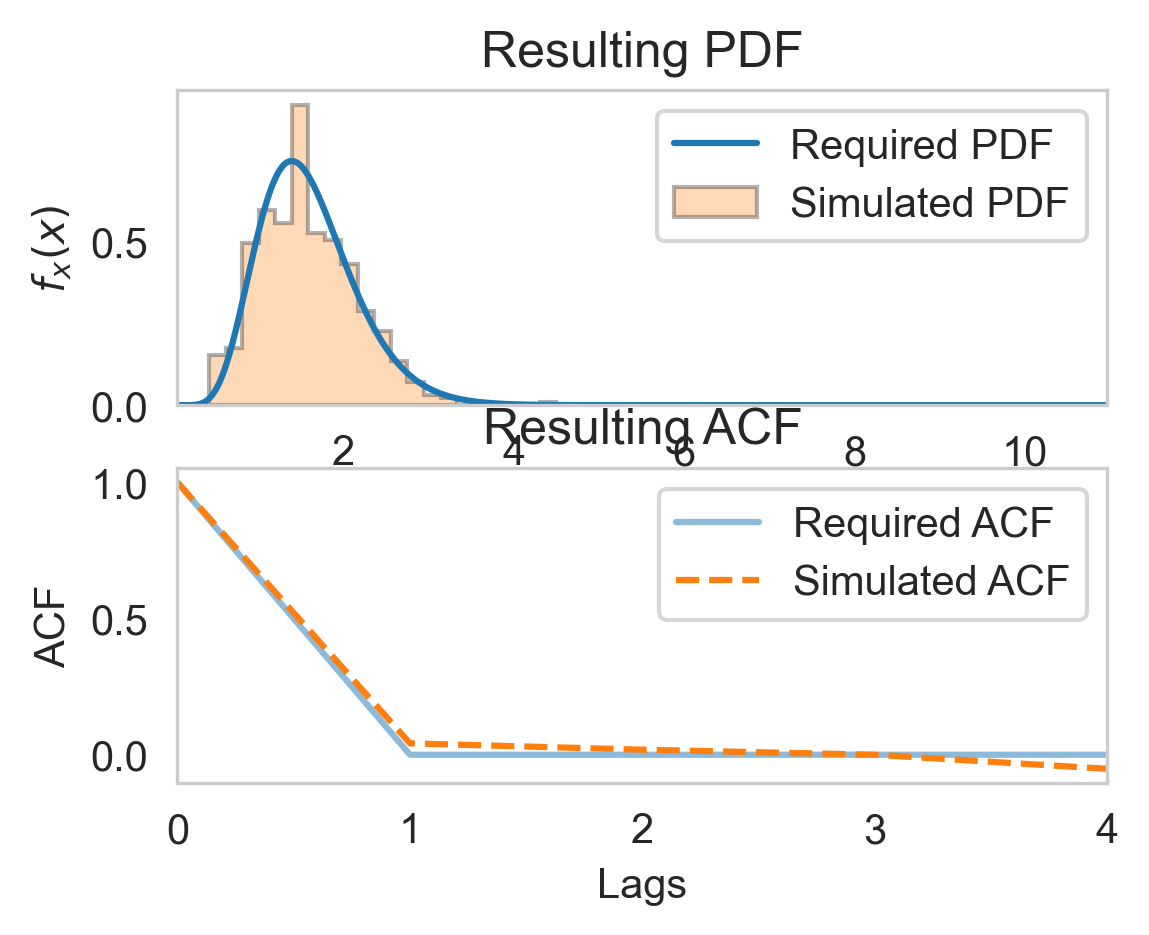

Mean 1.60 Var 0.32 ACF acf25


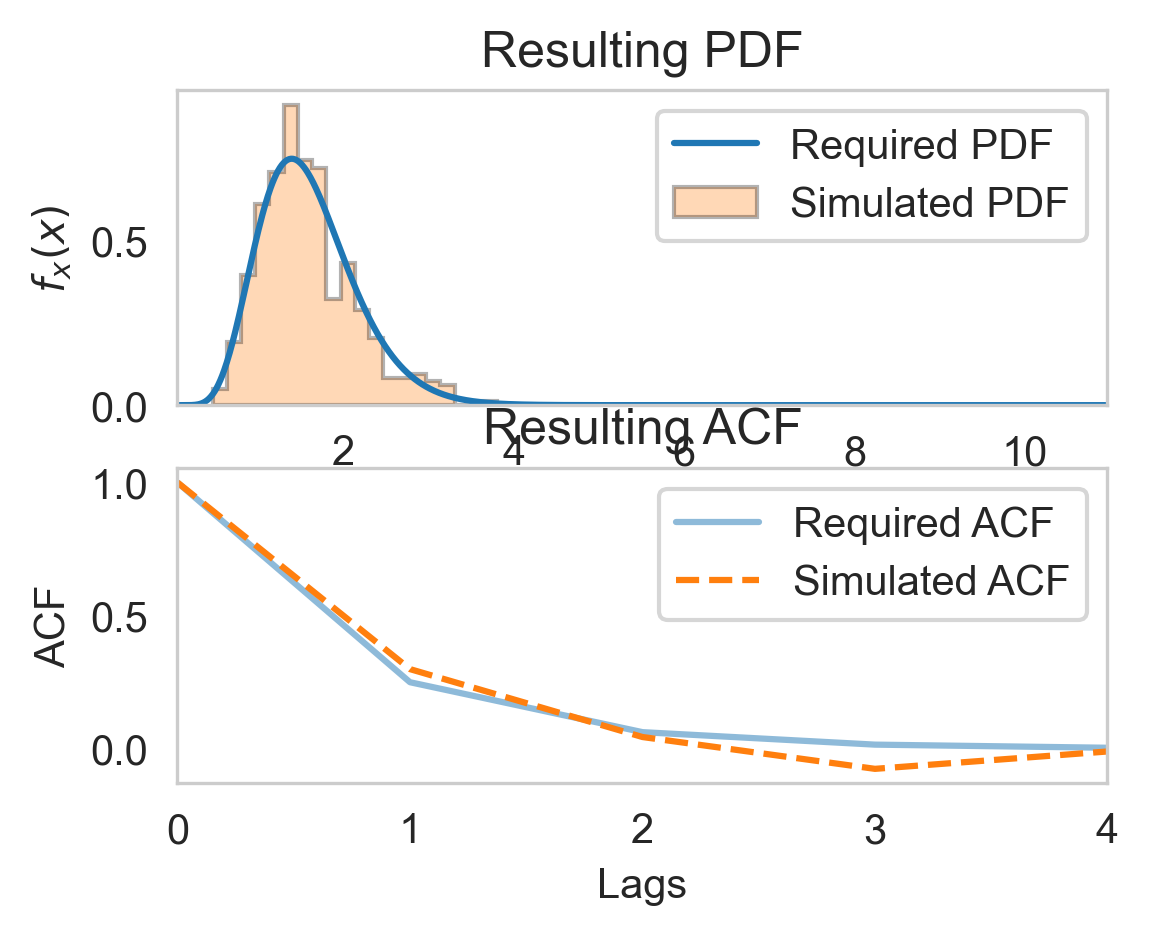

Mean 1.60 Var 0.32 ACF acf50


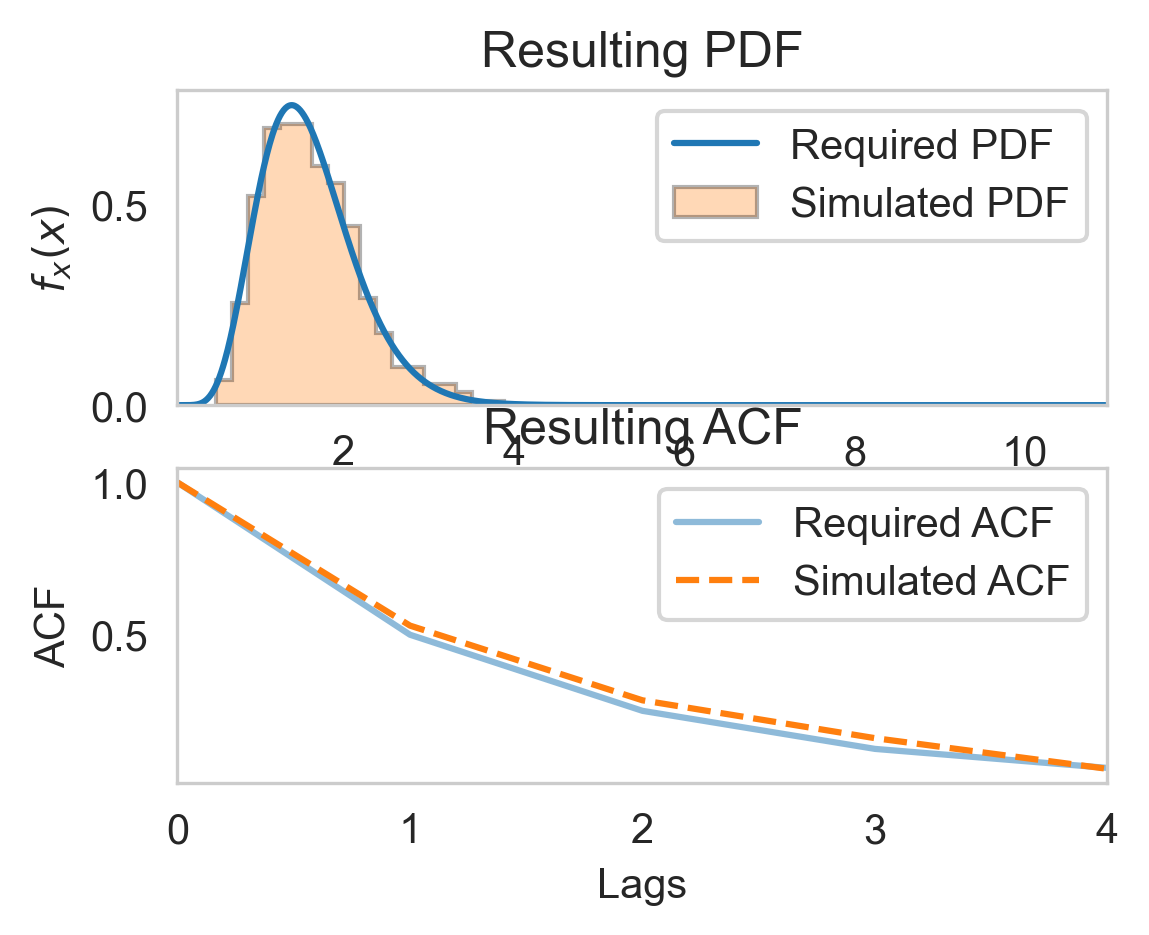

Mean 3.20 Var 0.64 ACF acf00


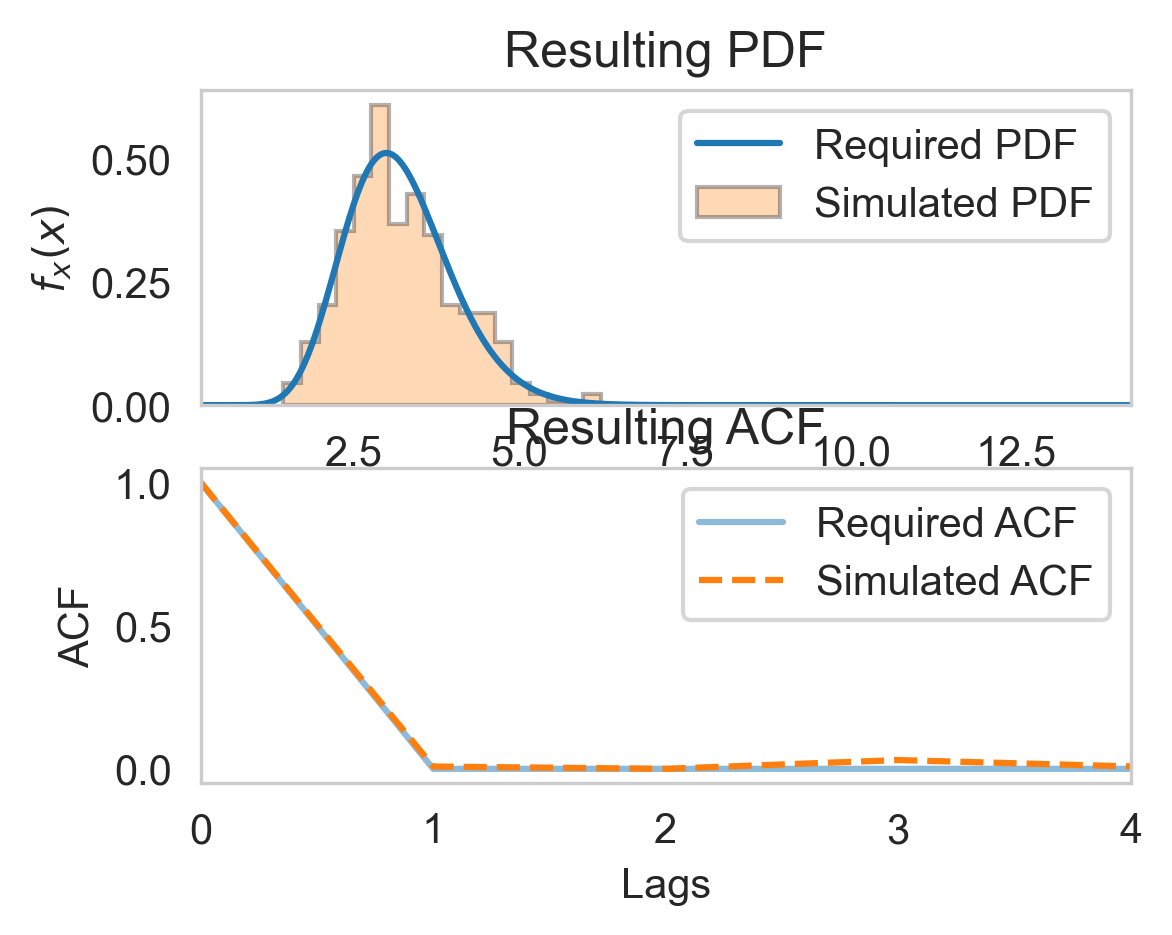

Mean 3.20 Var 0.64 ACF acf25


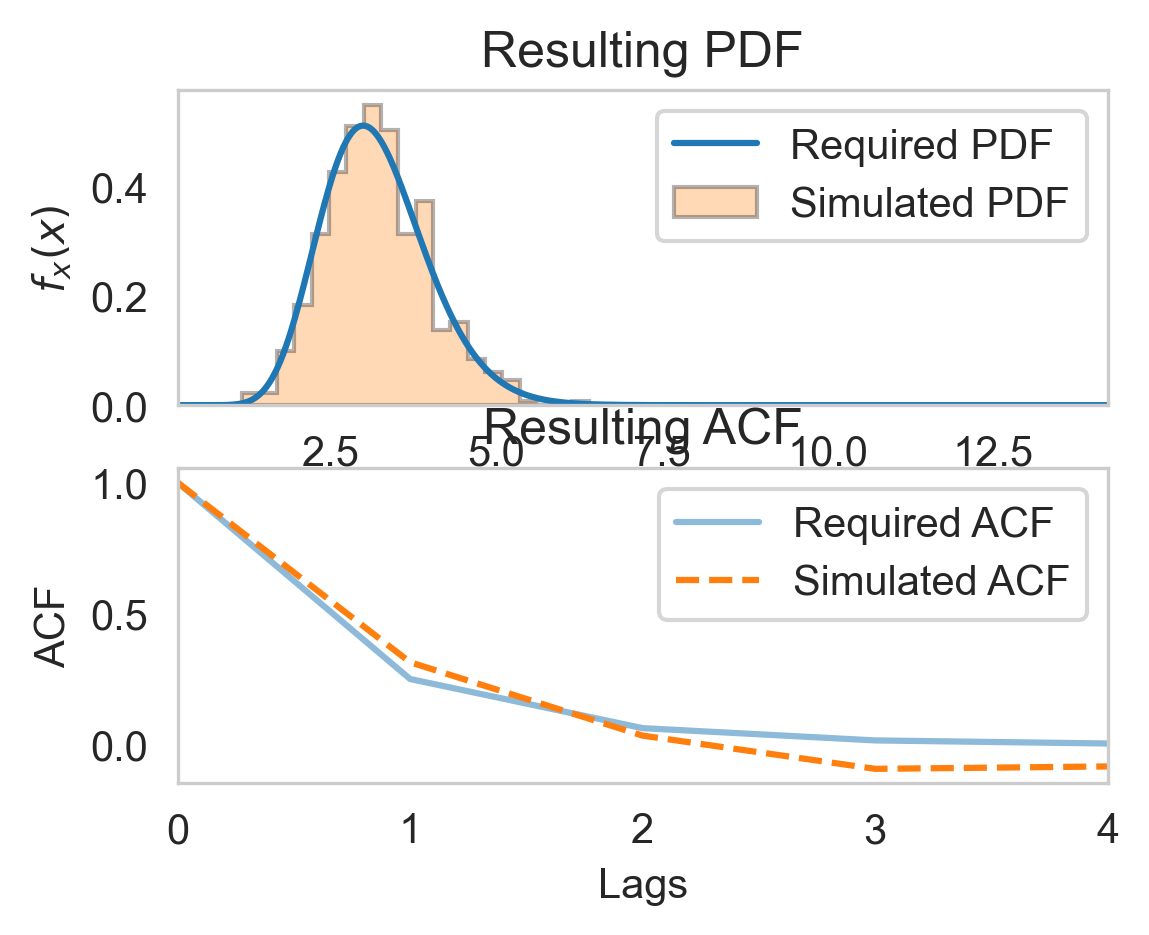

Mean 3.20 Var 0.64 ACF acf50


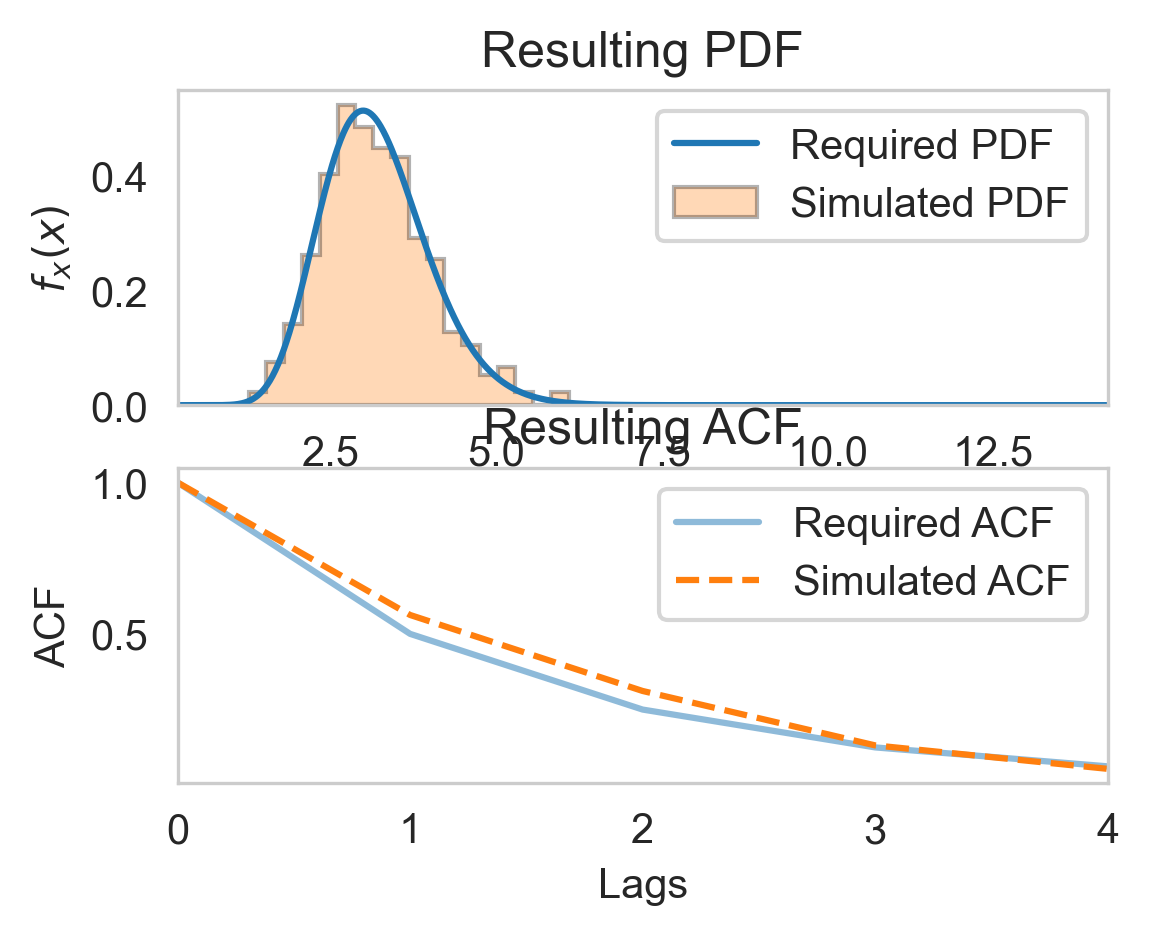

In [48]:
from itertools import product as it_prod

acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))
acf_00 = np.zeros(5)
acf_00[0] = 1.0

target_mean_var_s = (
    (2*0.050, 2*0.010),
    (2*0.100, 2*0.020),
    (2*0.200, 2*0.040),
    (2*0.400, 2*0.080),
    (2*0.800, 2*0.160),
    (2*1.600, 2*0.320),
)
loc = 0.046 #46

for (mean, var), (acf, acf_name) in it_prod(target_mean_var_s, ((acf_00, "acf00"), (acf_25, "acf25"), (acf_50, "acf50"))):    
    dist, _, _ = gamma_with_params(loc, mean, var)
    print(f"Mean {mean:0.02f} Var {var:0.02f} ACF {acf_name}")
    gen_corr_sequence(
        dist_obj=dist,
        L=500,
        target_acf=acf,
        debug=True,
    )